# A machine learning approach for the classification of cardiac arrhythmia
The aim of this project is to determine the type of arrhythmia from the ECG recordings.

Eleonora Detić

In [267]:
%matplotlib inline 
#ovo mi mozda kasnije stvara probleme
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats
from pca import pca

### Data loading

In [285]:
df = pd.read_csv('data_arrhythmia.csv', delimiter=';')
df.dataframeName = 'data_arrhythmia.csv'

In [231]:
#data_fake = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/arrhythmia/arrhythmia.data', header=None)
with open("arrhythmia.names") as f:
    print(f.read())

1. Title: Cardiac Arrhythmia Database

2. Sources:
   (a) Original owners od Database:
       -- 1. H. Altay Guvenir, PhD., 
             Bilkent University,
             Department of Computer Engineering and Information Science,
             06533 Ankara, Turkey
             Phone: +90 (312) 266 4133
             Email: guvenir@cs.bilkent.edu.tr

       -- 2. Burak Acar, M.S.,
             Bilkent University, 
             EE Eng. Dept. 
             06533 Ankara, Turkey
             Email: buraka@ee.bilkent.edu.tr

       -- 2. Haldun Muderrisoglu, M.D., Ph.D., 
             Baskent University, 
             School of Medicine
             Ankara, Turkey

   (b) Donor: H. Altay Guvenir
              Bilkent University,
              Department of Computer Engineering and Information Science,
              06533 Ankara, Turkey
              Phone: +90 (312) 266 4133
              Email: guvenir@cs.bilkent.edu.tr

   (c) Date: January, 1998

3. Past Usage:
   1. H. Altay Guvenir, Bura

### Data survey

#### Descriptive statistics

age                                                   
     count       mean        std  min   25%   50%   75%   max
sex                                                          
0    203.0  47.546798  16.519761  0.0  37.5  47.0  59.0  80.0
1    249.0  45.594378  16.404173  1.0  34.0  46.0  58.0  83.0

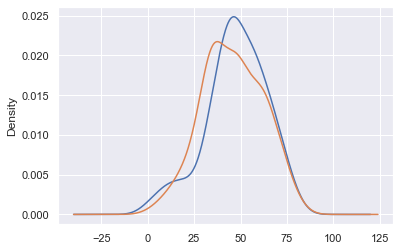

In [120]:
df.groupby('sex').age.plot(kind='kde') #vizualni prikaz
df[["sex", "age"]].groupby("sex").describe() #deskriptivna statistika

The above results show the distribution graph and descriptive statistics, for both women and men.

#### Missing values

In [266]:
df.shape
any(df.columns.duplicated()) #imena stupaca su mi unique

False

In [233]:
df.head()

,age,sex,height,weight,qrs_duration,p-r_interval,q-t_interval,t_interval,p_interval,qrs,...,KY,KZ,LA,LB,LC,LD,LE,LF,LG,diagnosis
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0,-0.1,3.9,25.4,62.8,7


In our data set, we have 452 patients and 279 features for each patient. Last column is interpreted as a number of heart arrhythmia claster. According to documentation, missing attribute values are distinguished with '?' so we will replace them with "NaN".

In [286]:
df = df.replace('?', np.NaN)
df.isna().sum().nlargest(10)

J               376
P                22
T                 8
QRST              1
heart_rate        1
age               0
sex               0
height            0
weight            0
qrs_duration      0
dtype: int64

As we can see, in column 'J' we have a lof of missing values, more than 80%, so we will drop that column.

In [287]:
df.drop(["J"], axis=1, inplace=True)

As for the other columns, since these variables are continuous, the first idea could be to hope for a normal distribution and then try to preserve the variability of the data by randomly simulate the missing values. <br> For this purpose, we perform well know **Kolmogorov–Smirnov** test.

In [8]:
print(stats.kstest(df[df['P'].notnull()]['P'].astype(int), 'norm'))
print(stats.kstest(df[df['T'].notnull()]['T'].astype(int), 'norm'))
print(stats.kstest(df[df['QRST'].notnull()]['QRST'].astype(int), 'norm'))
print(stats.kstest(df[df['heart_rate'].notnull()]['heart_rate'].astype(int), 'norm'))

KstestResult(statistic=0.9255811086972653, pvalue=0.0)
KstestResult(statistic=0.847749201067469, pvalue=0.0)
KstestResult(statistic=0.8168319201501881, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)


This assumption was obviously too ambitious. For all columns, the p value turned out to be very small and the test statistics very large. <br> So our conclusion is that at each standard level of significance, we reject the null hypothesis, that is, that our data **do not follow** a normal distribution. <br>
The next idea is standard. We will replace the missing values with the mean of each column.

In [288]:
imp= SimpleImputer(missing_values=np.NaN, strategy='mean')
idf=pd.DataFrame(imp.fit_transform(df))
idf.columns=df.columns
idf.index=df.index
df = idf

Finally, there are no more missing values in our data.

In [101]:
#df.isin([0]).sum(axis=0).nlargest(30) pitanje je dal izbacim te očite? -> ako su sve nule, il gotovo sve to mi ocito nista ne govori lol?

In [ ]:
#df.drop(["J","R'_wave","S'_wave", "AB", "AC", "AD","AE", "AF", "AG", "AL", "AN", "AO", "AP", "AR", "AS", "AT", "AZ", "AB'", "BC", "BD", "BE", "BG", "BH", "BP", "BR", "BS", "BT", "BU", "CA", "CD", "CE", "Cf", "CG", "CH", "CI", "CM","CN","CP","CR","CS","CT","CU","CV","DE","DF","DG","DH","DI","DJ","DR","DS","DT","DU","DV","DY","EG",
# "EH", "EL", "ER", "ET", "EU", "EV", "EY", "EZ", "FA", "FE", "FF", "FH", "FI", "FJ", "FK", "FL", "FM", "FR", "FS", "FU", "FV", "FY", "FZ", "GA",
# "GB", "GG", "GH", "HD", "HE", "HO", "IA", "IB", "IK", "IL", "IY", "JI", "JS", "JT", "KF", "KO", "KP", "LB", "LC", "T", "P", "QRST", "heart_rate"], axis=1, inplace=True)

## Principal Component Analysis

Before using PCA, the first step is scaling the features in our data. 

In [289]:
X = df.iloc[:,0:277].values
y = df.iloc[:,-1:].values
X = StandardScaler().fit_transform(X)

In [290]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

In [274]:
finalDf = pd.concat([principalDf, df[['diagnosis']]], axis = 1)

ValueError: too many values to unpack (expected 2)

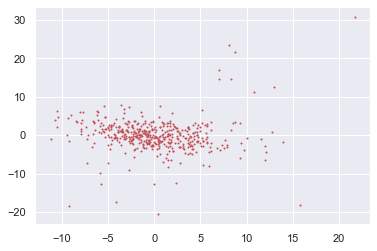

In [244]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',linewidth=2,shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)
plt.scatter(finalDf["PC1"],finalDf["PC2"], c="r",s=1)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 30 * np.sqrt(length) #obično skaliranje smjera vektora - provjeri ovaj dio
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

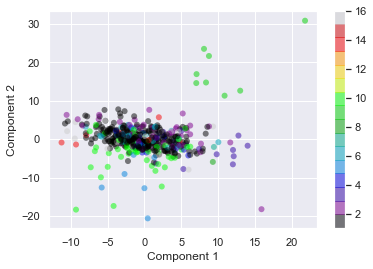

In [245]:
plt.scatter(finalDf["PC1"],finalDf["PC2"], c=finalDf.diagnosis, edgecolor='none', alpha=0.5,cmap=plt.cm.get_cmap('nipy_spectral', 16))
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar();

#### Scree plot

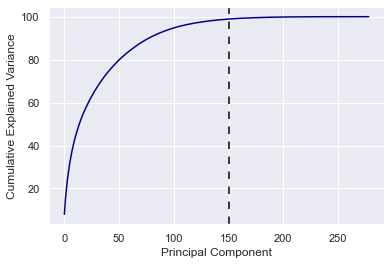

In [246]:
scaler = StandardScaler()
scaled_df=df.copy()
scaled_df=pd.DataFrame(scaler.fit_transform(scaled_df), columns=scaled_df.columns)
pca = PCA(n_components=279)
pca_fit = pca.fit(scaled_df)
PC_values = np.arange(pca.n_components_) + 1
plt.plot(np.cumsum(100 * pca.explained_variance_ratio_), color="darkblue")
#plt.title('Scree Plot') nisam sigurna jel ovo bas scree plot?
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.axvline(x=150, color="black", linestyle=(0, (5, 5)))
plt.show()

#print(pca.explained_variance_) #koliki smo postotak varijabilnosti objasnili

sada iz tog grafa zaključim da trebam 150 prvih PCA komponenta i te feature uzmem

#### Getting the most important features based on Principal Component Analysis

In [291]:
model = PCA(n_components=150).fit(X)
n_pcs= model.components_.shape[0]
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = scaled_df.columns.tolist()
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
df_ = pd.DataFrame(dic.items())

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [277] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [102] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[102]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


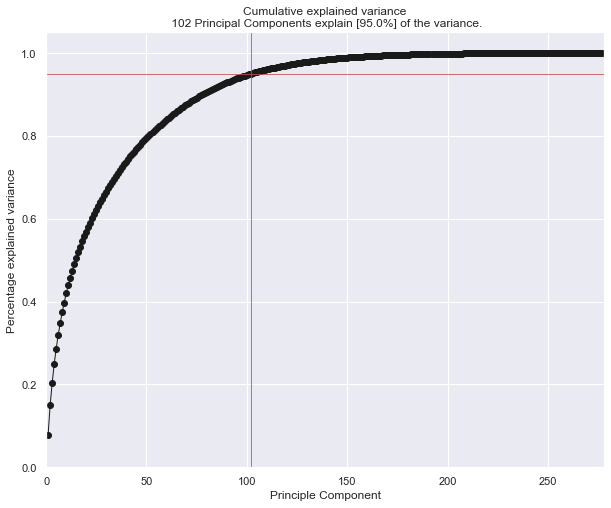

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Cumulative explained variance\n 102 Principal Components explain [95.0%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 432x288 with 0 Axes>

In [276]:
from pca import pca
model = pca()
# Fit transform
out = model.fit_transform(X)
model.plot()

In [175]:
#ax = model.biplot(n_feat=279, legend=False)

In [214]:
#ax = model.biplot3d(n_feat=279, legend=False)

In [277]:
#out['topfeat'].head(150)["feature"] drugi način al unique mi ih je 100 ?
important = df[1].tolist()
important

['HH',
 'LF',
 'JY',
 'qrs_duration',
 'IN',
 'FB',
 'JS',
 'IK',
 'HG',
 'GT',
 'DS',
 'AI',
 'HA',
 'KG',
 'KO',
 'IU',
 'IT',
 'FD',
 'BR',
 'CG',
 'JU',
 'KF',
 'IL',
 'HO',
 'AG',
 'DU',
 'AS',
 'LB',
 'HO',
 'FK',
 "AB'",
 'KF',
 'HE',
 'BT',
 'JP',
 'FY',
 'CM',
 'EK',
 'DI',
 'FK',
 'CV',
 'EG',
 'CV',
 'DF',
 'FU',
 'Cf',
 'Cf',
 'CE',
 'AE',
 'AP',
 'AK',
 'p_interval',
 'BS',
 'FV',
 'BP',
 'AE',
 'BE',
 'BS',
 'BE',
 'BE',
 'AE',
 'BC',
 'AE',
 'CU',
 'FV',
 'FV',
 'DG',
 'BE',
 'CU',
 'BC',
 'AD',
 'FP',
 'DJ',
 'GI',
 'BP',
 'EL',
 'AD',
 'DR',
 't_interval',
 'IZ',
 'EH',
 'ES',
 't_interval',
 'BH',
 'EL',
 'BO',
 't_interval',
 'CR',
 'EL',
 'DH',
 'DR',
 'BH',
 'BO',
 'AC',
 'GI',
 'EZ',
 'T',
 'CC',
 'AO',
 'BF',
 'AR',
 'EZ',
 'DI',
 'DF',
 'CP',
 'DR',
 'age',
 'GB',
 'DR',
 'EI',
 'AO',
 'DS',
 'EZ',
 'ES',
 'EK',
 'BB',
 'AM',
 'BZ',
 'heart_rate',
 'FM',
 'GB',
 'EF',
 'CV',
 'EF',
 'DP',
 'p-r_interval',
 'DF',
 'HF',
 'weight',
 'qrs',
 'AB',
 'QRST',
 'FO',
 

In [292]:
df[np.intersect1d(df.columns, important)]

,AB,AB',AC,AD,AE,AG,AI,AK,AM,AO,...,QRST,T,age,heart_rate,p-r_interval,p_interval,qrs,qrs_duration,t_interval,weight
0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,36.0,28.0,0.0,...,-2.0,13.0,75.0,63.000000,193.0,121.0,-16.0,91.0,174.0,80.0
1,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,24.0,0.0,...,31.0,37.0,56.0,53.000000,174.0,39.0,25.0,81.0,149.0,64.0
2,0.0,0.0,0.0,0.0,0.0,0.0,56.0,0.0,40.0,0.0,...,66.0,34.0,54.0,75.000000,163.0,102.0,96.0,138.0,185.0,95.0
3,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,36.0,0.0,...,20.0,11.0,55.0,71.000000,202.0,143.0,28.0,100.0,179.0,94.0
4,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,24.0,0.0,...,3.0,13.0,75.0,74.463415,181.0,103.0,-16.0,88.0,177.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0.0,32.0,0.0,...,-27.0,4.0,53.0,63.000000,199.0,117.0,-37.0,80.0,154.0,70.0
448,0.0,0.0,0.0,0.0,0.0,0.0,56.0,0.0,32.0,0.0,...,79.0,66.0,37.0,73.000000,137.0,73.0,86.0,100.0,201.0,85.0
449,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,32.0,0.0,...,-70.0,-19.0,36.0,84.000000,176.0,116.0,-85.0,108.0,194.0,68.0
450,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,40.0,0.0,...,43.0,29.0,32.0,80.000000,106.0,63.0,54.0,93.0,218.0,55.0


### Classification 

#### Support Vector Machine

#### Logistic Regression Algorithm

#### K-Nearest Neighbors Algorithm

#### Random Forest Algorithm

## Conclusion 

blablabla
-moguci redoslijed mozda
Data transformation
Data cleaning
Data validation
Data augmentation
Feature enginerring